# Visualizing loss curve #

- We use [tbparse](https://github.com/j3soon/tbparse) to export tensorboard readings.

- We also apply [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) for guessing if gradient descent is happening (may not represent actual learning process).

- [Online Tensorboard of AstolfoXL.](https://huggingface.co/tensorboard/6DammK9/AstolfoXL/)

- Due to the nature of gradient accumulation and multiple GPU training (as batch size), there will be multiple loss values in the same step. We can apply moving average with multiplied window size. For example, $2048 = 4 * 4 * 256$.

- [Interpreting loss curves.](https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves)

In [1]:
import os
import gc

# Fix for OMP: Error #15
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import nest_asyncio  # noqa: E402
nest_asyncio.apply()

In [2]:
import matplotlib.pyplot as plt
from tbparse import SummaryReader

from sklearn.linear_model import RidgeCV

import numpy as np

import pandas as pd
pd.options.mode.copy_on_write = True

In [3]:
log_dir = "E:/NOVELAI/astolfo_xl/tensorboard"
#log_dir = "E:/NOVELAI/astolfo_xl/tensorboard_pre"
#log_dir = "F:/NOVELAI/astolfo_xl/just_astolfo/tensorboard_dump/just_astolfo_25033101_20250406224210"

In [4]:
ma_size = 2048

In [5]:
reader = SummaryReader(log_dir)

In [6]:
df_raw = reader.scalars

In [7]:
df_raw

,step,tag,value
0,777917,epoch,1.000000
1,50000,loss,0.011546
2,50000,loss,0.005567
3,50000,loss,0.036591
4,50001,loss,0.044598
...,...,...,...
29323528,777916,lr/unet,0.000002
29323529,777916,lr/unet,0.000002
29323530,777916,lr/unet,0.000002
29323531,777916,lr/unet,0.000002


In [8]:
df_raw.keys()

Index(['step', 'tag', 'value'], dtype='object')

In [9]:
df = df_raw.loc[(df_raw['tag'] == "loss")]

In [10]:
df['ma'] = df['value'][:ma_size+64].rolling(window=ma_size).mean()

Text(0.5, 1.0, 'sample')

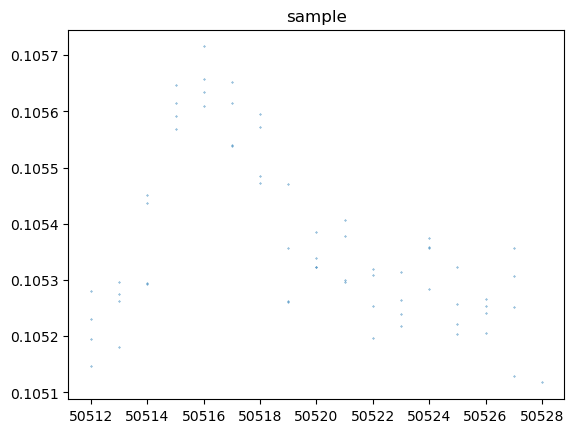

In [11]:
plt.scatter(df['step'],df['ma'],s=1e-1)
plt.title('sample')

In [12]:
df['ma'] = df['value'].rolling(window=ma_size).mean()

In [13]:
loss_avg = df['value'].mean()

- I am not predicting stuffs, so this will not be serious, for exmaple, adding Kernel.
- Transforming data as a "log-linear regression" is not preferred either.

In [21]:
init_step = 5e4
df['step2'] = df['step'] - init_step

In [23]:
clf = RidgeCV(alphas=(1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2))
clf.fit(df['step2'].values.reshape(-1,1), df['value'].values)

RidgeCV(alphas=(0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0))

- `coef_` < 0 when "converging" happens, `coef_` > 0 means "diverging" happens, if `coef_` close to 0, it is "oscillating". 
- `intercept_` is non zero regarding to task nature.
- `alpha_` and `best_score_` is the CV result. ~~alpha=1.0 should works by default.~~

In [24]:

print(clf.coef_[0], clf.intercept_, clf.alpha_, clf.best_score_)

0.0014801025390625 -536.2205157658508 0.0001 -0.008478327358907039


- `clf_r2` is the $R^2$ score of the y axis, which is $[-\infty,1.0]$.
- $R^2 > 0$ means prediction follows the trend of data.
- $R^2 = 0$ means prediction doesn't follow the trend, or there is no trend of data.
- $R^2 < 0$ means prediction against the trend of data.

In [25]:
clf_r2 = clf.score(df['step'].values.reshape(-1,1), df['value'].values)

Text(0.5, 1.0, 'loss=MSE, avg=0.1028, slope=1.5e-03, r2=-1.2e+07')

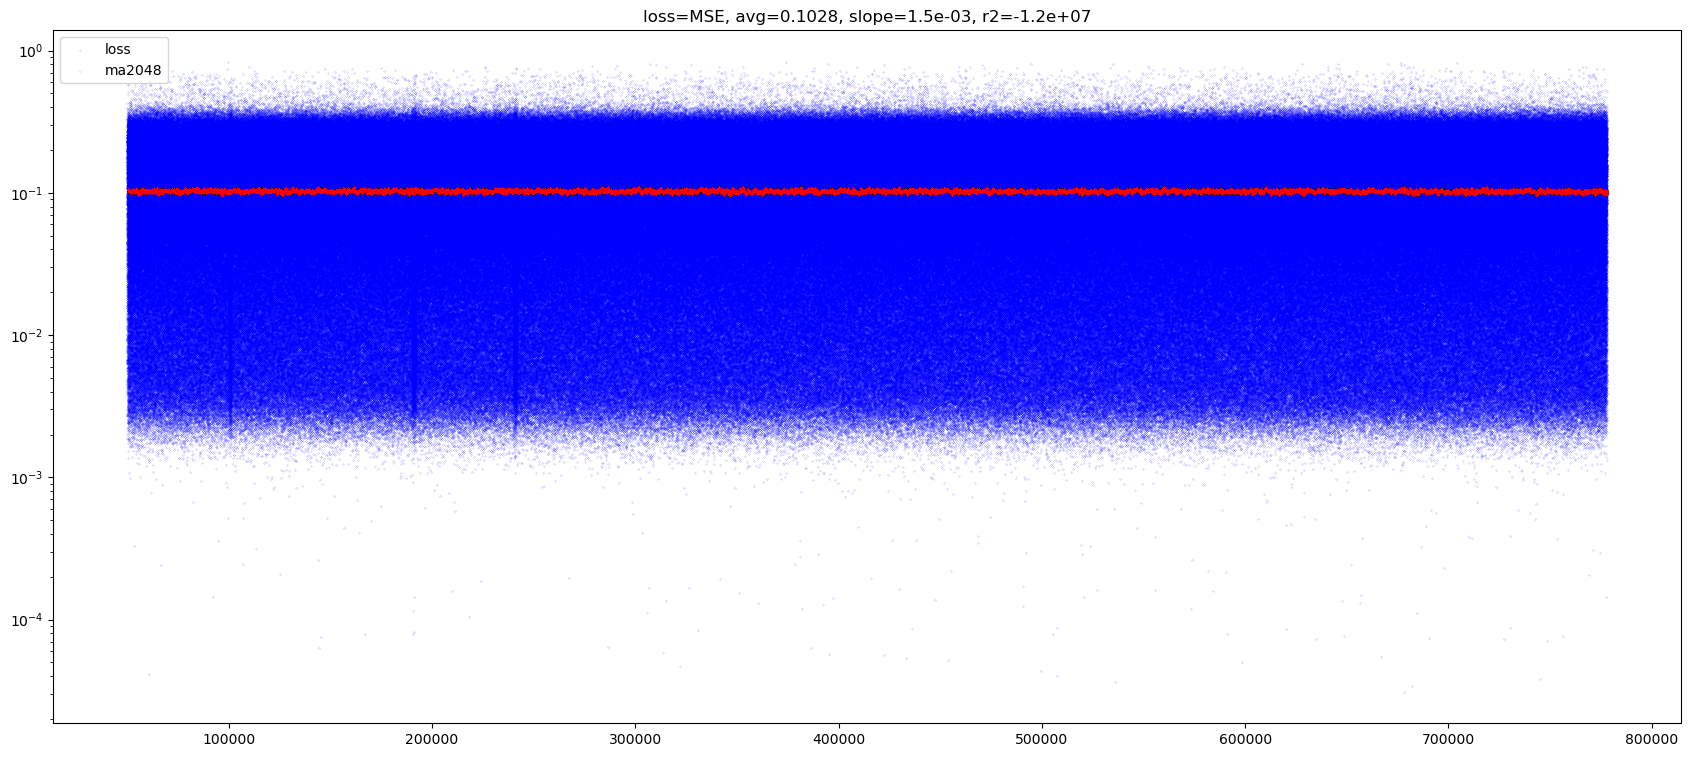

In [26]:
fig = plt.figure(figsize=(21, 9))
ax1 = fig.add_subplot(111)
ax1.scatter(df['step'],df['value'],s=1e-2,c='b',label=f"loss")
ax1.scatter(df['step'],df['ma'],s=1e-2,c='r',label=f"ma{ma_size}")
ax1.set_yscale('log')
plt.legend(loc='upper left')
plt.title('loss=MSE, avg={:.4f}, slope={:.1e}, r2={:.1e}'.format(loss_avg, clf.coef_[0],clf_r2))

In [27]:
fig.savefig('loss_full.png')